# LJP

100 0.0000 -0.0000 16065.5709 12611.1645 16062.1067 12613.5924 85.7241 67.2305
200 0.0000 -0.0000 28381.9823 0.0941 28381.9549 0.1252 151.3710 0.0028
300 0.0000 -0.0000 28382.0212 0.0000 28382.0213 0.0000 151.3708 0.0000
400 0.0000 -0.0000 28382.0212 0.0000 28382.0212 0.0000 151.3708 0.0000
500 0.0000 -0.0000 28382.0212 0.0000 28382.0212 0.0000 151.3708 0.0000


,timestep,timeNow,$\Sigma v$,E,$\sigma E$,Ek,$\sigma Ek$,P_1,P_2
0,100,0.0,-8.188468e-08,16065.570944,12611.164513,16062.106666,12613.592417,85.724129,67.230459
1,200,0.0,-8.188468e-08,28381.982293,0.094072,28381.954854,0.125249,151.371033,0.002763
2,300,0.0,-8.188468e-08,28382.021238,0.000000,28382.021293,0.000000,151.370777,0.000005
3,400,0.0,-8.188468e-08,28382.021151,0.000000,28382.021151,0.000000,151.370779,0.000007
4,500,0.0,-8.188468e-08,28382.021151,0.000000,28382.021151,0.000000,151.370779,0.000007


Text(0.5, 1.0, 'Temperature vs Time')

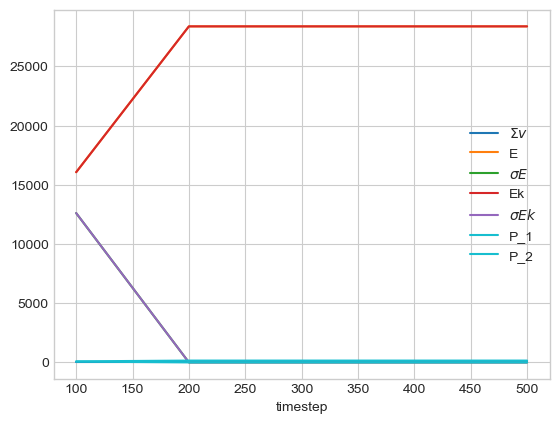

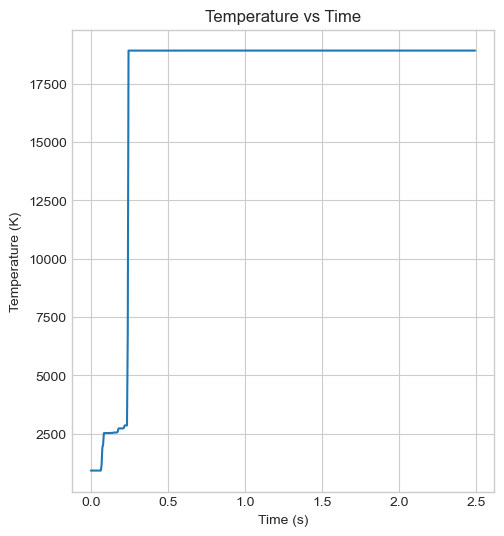

In [20]:
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np
from PIL import Image
import glob
from datetime import datetime
import time
import os.path
from os import path
import shutil
from IPython.display import display
import random
import scipy.stats as stats
from scipy.spatial.distance import cdist

kb=1 #玻耳兹曼常量；波尔兹曼常数
N=6**3 #原子的个数
L=30.0 #盒子的边长
mass=1 #原子的质量
dt=0.005 #步长 单位  秒
T=300 #温度 
stepLimit=500 #步数
stepAvg=100
stepEquil=0
stepCount =0
# 氩-氩相互作用的LJ势参数:
epsilon =  1
sigma = 1
rc=2.5*sigma #截止距离，LJ电势在截止距离处被截断
V_0=1.0 #高斯势阱深度
a = 1.0 
s = -0.01 #高斯势阱变化率
rc_g = 3/np.sqrt(a) #高斯势阱的截断距离
timeNow = stepCount * dt   #模拟运行的时间=步数x步长

#随时间变化的矩形高斯势阱
def GaussianForce(v):
    global V_0
    r = norm(v)
    V_0 = V_0 + s*timeNow
    force = np.multiply((-V_0 * 2 * a * np.exp(-a*r*r)), v) 
    return force
class Mol():
    def __init__(self,pos,vel,a):
        #初始化以上属性的值
        self.pos=np.asarray([0.0,0.0,0.0])
        self.vel=np.asarray([0.0,0.0,0.0])
        self.a=np.asarray([0.0,0.0,0.0])
        
# 体系属性类，主要用来求体系属性（测定量）的平均值和标准差        
class Prop():
   def __init__(self, val, sum, sum_squ):
        self.val=val                       #体系测定量的值
        self.sum=sum                       #体系测定量的值的和
        self.sum_squ=sum_squ               #体系测定量的值的平方和
   
    # 返回平方和立方值的函数：
def Sqr(x):
    return (x * x)


def Cube(x):
    return ((x) * (x) * (x))

def norm(v):
    return np.sqrt(v[0]*v[0]+v[1]*v[1]+v[2]*v[2])

#初始化值
def PropZero(v):
    v.sum = v.sum_squ = 0.
    return v    
#求和与平方和    
def PropAccum(v):
    v.sum += v.val
    v.sum_squ += Sqr(v.val)
    return v    

#求平均值和标准差
def PropAvg(v, n):
    v.sum /= n
    v.sum_squ = math.sqrt(max(v.sum_squ / n - Sqr(v.sum), 0.)) 
    return v 


# AccumProps：收集测定量的结果，并根据要求计算平均值和标准偏差。
def AccumProps(icode):
    
    if icode == 0:             # 0：初始化                                            
        PropZero(totEnergy)
        PropZero(kinEnergy)
        PropZero(pressure) 
    if icode == 1:            # 1：求和                    
        PropAccum(totEnergy)
        PropAccum(kinEnergy)
        PropAccum(pressure)    
    if icode == 2:           # 2：求平均值和标准差
        PropAvg(totEnergy, stepAvg)
        PropAvg(kinEnergy, stepAvg)
        PropAvg(pressure, stepAvg) 
                          
def LeapfrogStep(part):
    if part == 1:
        for n in range (N):
            mol[n].vel=np.add(mol[n].vel,np.multiply(0.5 * dt,mol[n].a))
            mol[n].pos=np.add(mol[n].pos,np.multiply(dt,mol[n].vel))
    else :
        for n in range(N):
            mol[n].vel=np.add(mol[n].vel,np.multiply(0.5 * dt,mol[n].a))           

def ComputeForces():
    global virSum                    #用于计算压强的中间变量（fij*rij）和
    global uSum                      #LJ势能和
    fcVal=0                          # 原子j对原子i施加的力
    rrCut=Sqr(rc)                  # rCut:Rc,截断半径的平方
    
    #初始化分子加速度
    for n in range (N):
        mol[n].a=np.zeros(mol[n].a.shape)
        
    uSum=0.                        #初始化LJ势能和值
    virSum=0.
    n=0
    for j1 in range(N-1):
        for j2 in range(j1+1,N):
            
            # 使Delta Rij。(RJ1-RJ2的平方之和)
            dr=np.subtract(mol[j1].pos,mol[j2].pos) # dr包含Rj1和Rj2之间的x,y坐标差值
            rr=(dr[0] * dr[0] + dr[1] * dr[1]+ dr[2]*dr[2]) #两原子距离的平方，这里并未求两原子间距离的绝对值，没必要，因为与截断半径只是比大小，省去了平方根的计算
            r=np.sqrt(rr)                      #r两为原子间的距离     
            
            # 这里是使用原子距离的平方来 dr2 < Rc^2 来判断两原子键相互作用力，
            if (rr < rrCut):
           
                #完整的LJ势能计算
                fcVal = 48 * epsilon * np.power(sigma, 12) / np.power(r, 14) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 8)
                # 更新加速度由LJ
                mol[j1].a = np.add(mol[j1].a, np.divide(np.multiply(fcVal, dr),mass))
                mol[j2].a = np.add(mol[j2].a, np.divide(np.multiply(-fcVal, dr),mass))
                #由高斯势阱
                if (norm(mol[j1].pos) < rc_g):
                    mol[j1].a = np.add(mol[j1].a, np.divide(GaussianForce(mol[j1].pos),mass))
                if (norm(mol[j2].pos) < rc_g):
                    mol[j2].a = np.add(mol[j2].a, np.divide(GaussianForce(mol[j2].pos),mass))
                #LJ势能计算
                uSum += 4 * epsilon * np.power(sigma/r, 12)/r - np.power(sigma/r, 6)    
                virSum += fcVal * rr

# 计算体系热力学属性值（测定值）
def EvalProps():
    global vSum
    vvSum = 0.                    #系统速度平方的总和
    vSum = np.zeros(vSum.shape)   #质心速度，为系统速度=各质点速度总和，初始化为[0,0]
    
    global kinEnergy                 #动能
    global totEnergy                #总能量
    global pressure                  #压强
    
    #求得质心速度
    for n in range(N):
        if (norm(mol[n]<rc_g))
        vSum =np.add(vSum,mol[n].vel)                                        
        vv = (mol[n].vel[0] * mol[n].vel[0] + mol[n].vel[1] * mol[n].vel[1] + mol[n].vel[2] * mol[n].vel[2])   #xv^2+yv^2+zv^2
        vvSum += vv
        
        # 在三维分子体系中，热力学属性值的数值计算方法
    kinEnergy.val = (0.5 * vvSum) / N                        #单个原子动能，N代表原子数
    temp = (kinEnergy.val*2)/(3*kb)
    totEnergy.val = kinEnergy.val + (uSum / N)                #总能量：单个原子的动能+单个原子的势能
    pressure.val =  (vvSum + virSum) / (3* Cube(L))    #体系压强
    temps.append(temp)

# 打印输出体系的测定量
def PrintSummary():
    #打印测定量，保留小数点后四位
    print(stepCount, \
          "{0:.4f}".format(timeNow), \
          "{0:.4f}".format(vSum[0] / N) ,\
          "{0:.4f}".format(totEnergy.sum),\
          "{0:.4f}".format(totEnergy.sum_squ), \
          "{0:.4f}".format(kinEnergy.sum), \
          "{0:.4f}".format(kinEnergy.sum_squ),\
          "{0:.4f}".format(pressure.sum),\
          "{0:.4f}".format(pressure.sum_squ))
    
    #返回精确的测定量值
    return (stepCount, \
          timeNow, \
          (vSum[0] / N) ,\
          totEnergy.sum,\
          totEnergy.sum_squ, \
          kinEnergy.sum, \
          kinEnergy.sum_squ,\
          pressure.sum,\
          pressure.sum_squ)    

def SingleStep():

    global timeNow   #  模拟运行时间
    global stepCount

    stepCount +=1                   
    LeapfrogStep(1)                #求解运动方程积分
    
    ComputeForces()              # 计算原子间相互作用力
    LeapfrogStep(2)             # 坐标和速度的积分
    EvalProps()                #计算系统属性值（速度，速度平方和，总能量，动能，压力,温度）
    AccumProps(1)             #系统属性值求和
    
    #每一百步统计系统的属性值（0,100,200,300,400,500），可以设置stepAvg的值进行自定义
    if (stepCount % stepAvg == 0):
        AccumProps(2)                         #求系统的属性值的平均值和标准差
        systemParams.append(PrintSummary())   #将结果加入到 systemParams列表中
        AccumProps(0)                         # 重置系统属性值用来下一次的统计   

#绘制和系统属性之相关的图像
def GraphOutput():
   
    ax = \
    df_systemParams.plot(x="timestep", y='$\Sigma v$', kind="line")
    df_systemParams.plot(x="timestep", y='E', kind="line", ax=ax, color="C1")
    df_systemParams.plot(x="timestep", y='$\sigma E$', kind="line", ax=ax, color="C2")
    df_systemParams.plot(x="timestep",  y='Ek', kind="line", ax=ax, color="C3")
    df_systemParams.plot(x="timestep", y='$\sigma Ek$', kind="line", ax=ax, color="C4")
    df_systemParams.plot(x="timestep", y='P_1', kind="line", ax=ax, color="C9")
    df_systemParams.plot(x="timestep", y='P_2', kind="line", ax=ax, color="C9")
    
    plt.savefig('plot.jpg', dpi=300)      


temp = T
vSum = np.asarray([0.0, 0.0, 0.0])   #速度之和
kinEnergy =Prop(0.0, 0.0, 0.0)  #动能
totEnergy =Prop(0.0, 0.0, 0.0)  #势能
pressure  =Prop(0.0, 0.0, 0.0)  #压强

mol = [Mol(np.asarray([0.0, 0.0, 0.0]), \
           np.asarray([0.0, 0.0, 0.0]), \
           np.asarray([0.0, 0.0, 0.0])) for i in range(N)]       #初始化分子

systemParams = []              #初始化系统参数列表
temps = []                     #初始化温度列表

# 初始化分子位置
n = int(np.cbrt(N))  # 每個維度上的分子數
d = L / n  # 分子間距
for i in range(N):
    x = (i+1)//Sqr(n)
    y = ((i+1)%Sqr(n))//n
    z = ((i+1)%Sqr(n))-y*n
    mol[i].pos = np.array([ x*d- L / 2 +d/2, y*d - L / 2 +d/2, z*d - L / 2+d/2 ])

               
#初始化分子速度    
for i in range(N):
    mol[i].vel = np.multiply(stats.maxwell.rvs(loc=0, scale=np.sqrt(kb * T / mass),  size=3), \
                             np.array([random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])]))     
    vSum = np.add(vSum, mol[i].vel)
      
vSum = np.divide(vSum, N)
for i in range(N):
    mol[i].vel=np.subtract(mol[i].vel,vSum)   # 調整速度分佈,使總動量為零
    
moreCycles = 1                                #MD循环控制开关变量1：run; 0:stop
workdir = str(os.getcwd()+'/')  


# 如果/LJP目录不存在，就建立它，否则就删除/LJP（和它的内容）
# 创建一个新的/LJP目录。
   
with open('LJP/data.xyz', 'w') as f:              
    while moreCycles:                            #MD循环
        SingleStep()                          #求解每一步的运动方程
        f.write(f"{N}\nFrame {stepCount}\n")
        for i in range(len(mol)):
            f.write(f"Ar {mol[i].pos[0]:.4f} {mol[i].pos[1]:.4f} {mol[i].pos[2]:.4f}\n")           
        if stepCount >= stepLimit:
            moreCycles = 0

#输出模拟过程中生成的参数
columns = ['timestep','timeNow', '$\Sigma v$', 'E', '$\sigma E$', 'Ek', '$\sigma Ek$', 'P_1', 'P_2']
df_systemParams = pd.DataFrame(systemParams, columns=columns)   

#绘制表格，仅在jupyter notebook使用，打印出数据列表
display(df_systemParams) 
GraphOutput()                 #输出体系测定量随模拟时间变化的图像

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(stepLimit) * dt, temps)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs Time')

In [40]:
import scipy.stats as stats
from scipy.spatial.distance import cdist
m=1
kb=1
T=1
for i in range(N):
    mol[i].vel = stats.maxwell.rvs(loc=0, scale=np.sqrt(kb * T / m),  size=3)     
    vSum = np.add(vSum, mol[i].vel)
      
vSum = np.divide(vSum, N)
for i in range(N):
    mol[i].vel=np.subtract(mol[i].vel,vSum) 
mol[1].vel

array([-0.6464647 , -0.91937128,  0.24861492])

In [18]:
np.array([random.choice([-1, 1]), random.choice([-1, 1]), random.choice([-1, 1])])                
#初始化分子速度    

array([-1,  1,  1])